In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import ast
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
def plot_the_loss_curve(epochs, mae_training, mae_validation):

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  plt.plot(epochs[3:], mae_training[3:], label="Training Loss")
  plt.plot(epochs[3:], mae_validation[3:], label="Validation Loss")
  plt.legend()
  
  # We're not going to plot the first epoch, since the loss on the first epoch
  # is often substantially greater than the loss for other epochs.
  merged_mae_lists = mae_training[1:] + mae_validation[1:]
  highest_loss = max(merged_mae_lists)
  lowest_loss = min(merged_mae_lists)
  delta = highest_loss - lowest_loss
  print(delta)

  top_of_y_axis = highest_loss + (delta * 0.05)
  bottom_of_y_axis = lowest_loss - (delta * 0.05)
   
  plt.ylim([bottom_of_y_axis, top_of_y_axis])
  plt.show() 

In [4]:
l_min = 1
l_max = 1

n_l = 1  # defined only one value for L, for now.

q_min = 10 * 10 ** 4
q_max = 100 * 10 ** 4

n_q = 5

E_min = 210 * 10 ** 9
E_max = 300 * 10 ** 9

n_E = 5

I_min = 1 * 10 ** (-5)
I_max = 10 * 10 ** (-5)

n_I = 5

# Will make the vectors linearly spaced, but it's not necessary
l_vec = np.linspace(l_min, l_max, n_l)
q_vec = np.linspace(q_min, q_max, n_q)
E_vec = np.linspace(E_min, E_max, n_E)
I_vec = np.linspace(I_min, I_max, n_I)

In [5]:
# Compute all possible permutations and arrange them in a matrix

per_list = []
for i in range(len(l_vec)):
    for j in range(len(q_vec)):
        for k in range(len(E_vec)):
            for l in range(len(I_vec)):
                per_list = np.append(per_list, np.array([[l_vec[i], q_vec[j], E_vec[k], I_vec[l]]]))

per_list = per_list.reshape(-1, 4)

# Shuffle the permutations
np.random.shuffle(per_list)

np.save('125_combinations', per_list)  # saved as an .npy file to use later using np.load('125_combinations')

In [6]:
# analytical solution for the beam bending problem

def ana_sol(n, l, q, E, I):
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * l ** 3) / (24 * E * I)
    y = (1 / (E * I)) * (((q * l) / 12) * x ** 3 - (q / 24) * x ** 4) + c_1 * x

    return [x, y]

def ana_sol_with_noise(n, param_list,noise):
    l=param_list[0]
    q=param_list[1]
    E=param_list[2]
    I=param_list[3]
    x_min = 0
    x_max = l
    x = np.linspace(x_min, x_max, n)
    y = np.zeros(len(x))
    c_1 = -(q * l ** 3) / (24 * E * I)
    y = (1 / (E * I)) * (((q * l) / 12) * x ** 3 - (q / 24) * x ** 4) + c_1 * x
    y = y + noise * (np.random.random(len(y)) - 0.5) * (np.max(y) - np.min(y))

    return [x, y]

In [7]:
#alternative way to generate fake data with noise
n = 1000
# Add noise
noise_factor = 0.2
#create dictionary with generated data
fake_data = {}
#dict keys: list of parameters values
#dict values: (x,y) array 
for i in per_list:
    fake_data[repr(i.tolist())] = ana_sol_with_noise(n, i, noise_factor)

In [8]:
#for each entry combination of (l,q,E,I) we have two columns of fake data: both x and noisy y 
fake_dataframe=pd.DataFrame.from_dict(fake_data,orient='index',columns=['x', 'y'])
#I will now dstructure the data in such a way that we are able to immediatly assess 
# which entry combination of (l,q,E,I) gives a specific (x,Y)
#let's clean a little
fake_dataframe=fake_dataframe.rename_axis('parameters').reset_index()
fake_dataframe.parameters=[eval(fake_dataframe.parameters[i]) for i in range(len(fake_dataframe))]
fake_dataframe[['l','q','E','I']] = pd.DataFrame(fake_dataframe.parameters.tolist(), index= fake_dataframe.index)
fake_dataframe=fake_dataframe.drop(columns='parameters')
#let's see an example of structured data
fake_dataframe

,x,y,l,q,E,I
0,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-5.104886035428613e-06, -1.5684787997750715e-...",1.0,100000.0,2.100000e+11,0.000055
1,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-5.155464902533458e-06, -1.3036164017051031e-...",1.0,100000.0,2.100000e+11,0.000033
2,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-1.1254871115342848e-05, -2.0510084154195275e...",1.0,775000.0,2.775000e+11,0.000077
3,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-8.238853887837966e-05, 3.0218287938296756e-0...",1.0,1000000.0,2.775000e+11,0.000055
4,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-3.109386098166265e-06, 2.8653208083856782e-0...",1.0,100000.0,2.325000e+11,0.000100
...,...,...,...,...,...,...
120,"[0.0, 0.001001001001001001, 0.0020020020020020...","[8.447946277425857e-06, -8.417439115279671e-06...",1.0,325000.0,3.000000e+11,0.000077
121,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-2.1632759811644223e-06, 1.6872758234764994e-...",1.0,100000.0,3.000000e+11,0.000077
122,"[0.0, 0.001001001001001001, 0.0020020020020020...","[-0.0002350287549071638, 0.0002552624247505479...",1.0,775000.0,2.775000e+11,0.000010
123,"[0.0, 0.001001001001001001, 0.0020020020020020...","[8.530340350475091e-06, 0.00014480802848578525...",1.0,550000.0,3.000000e+11,0.000010


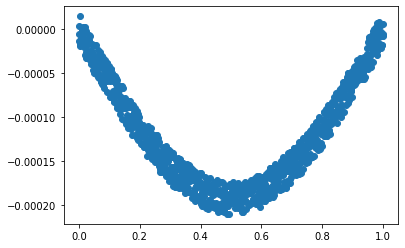

In [9]:
#plot the 1st entry of the dataframe
plt.scatter(fake_dataframe['x'][1],fake_dataframe['y'][1],label=str(fake_dataframe.index[1]))
plt.show()

In [10]:
#with the dataset organized is much easier to split the data.
#https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
#let's take a look at an example 
test_split=0.1 #we will use 10% of the data for testing. 
df = fake_dataframe
train_df, test_df = train_test_split(df, test_size = test_split)

In [11]:
#the training data will be spllited automatically by 80/20 during training using keras framework. 
# no need to split at this stage.
#let's check the array shapes: 
print('Training set: ',train_df.shape)
print('Test set: ',test_df.shape)

train_size = train_df.shape[0]
test_size = test_df.shape[0]

Training set:  (112, 6)
Test set:  (13, 6)


C:\Users\luisf\.conda\envs\tf\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


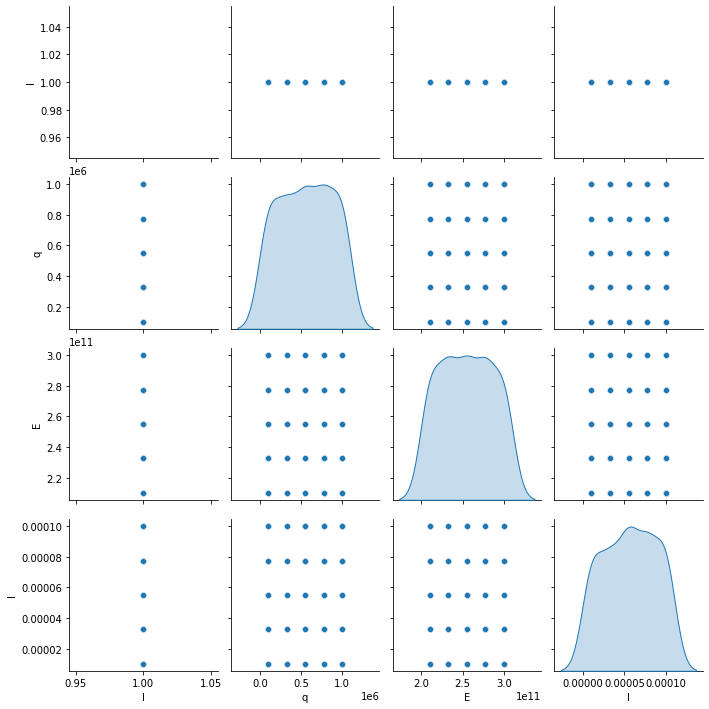

In [12]:
#inspect the training dataset
sns.pairplot(train_df[['l', 'q', 'E', 'I']], diag_kind='kde')

In [13]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
l,112.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
q,112.0,5.580357e+05,3.195262e+05,1.000000e+05,3.250000e+05,5.500000e+05,7.750000e+05,1.000000e+06
E,112.0,2.545982e+11,3.152925e+10,2.100000e+11,2.325000e+11,2.550000e+11,2.775000e+11,3.000000e+11
I,112.0,5.640625e-05,3.157249e-05,1.000000e-05,3.250000e-05,5.500000e-05,7.750000e-05,1.000000e-04


In [14]:
# follow this tutorial for our data 
# https://www.tensorflow.org/tutorials/keras/regression
# whenever possible, add comments and discussion

In [15]:
# get the max "y" for each entry
df.y.apply(min)
# at this point we could plot very interesting stuff such as ymax distributions on the vars (q,l,E,I)...
# but let's think about that later

0     -0.000123
1     -0.000210
2     -0.000515
3     -0.000934
4     -0.000062
         ...   
120   -0.000200
121   -0.000061
122   -0.003974
123   -0.002624
124   -0.000559
Name: y, Length: 125, dtype: float64

In [16]:
# I have fixed the value of L as 1.0 for now, so I am not using the values of [x,y] as inputs, only the values of y.

In [17]:
# Allocate the features and the labels in different DataFrames.

train_features = train_df.copy()
test_features = test_df.copy()

# train_labels = pd.DataFrame([train_features.pop('l'), train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
# train_labels = train_labels.T
# test_labels = pd.DataFrame([test_features.pop('l'), test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
# test_labels = test_labels.T

train_labels = pd.DataFrame([train_features.pop('q'), train_features.pop('E'), train_features.pop('I')])
train_labels = train_labels.T
test_labels = pd.DataFrame([test_features.pop('q'), test_features.pop('E'), test_features.pop('I')])
test_labels = test_labels.T

In [ ]:
# I'm not yet sure what would be the correct way to normalize the values of y, as they are in the shape of vectors.

In [18]:
feature_columns = []

# Will not include the values of x
# x_col = tf.feature_column.numeric_column("x")
# feature_columns.append(x_col)
y_col = tf.feature_column.numeric_column("y")
feature_columns.append(y_col)

my_feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [19]:
# Build the model and define its architecture.

In [20]:
inputs = keras.Input(shape=(n))

In [21]:
dense = layers.Dense(512, activation="relu")
x = dense(inputs)

In [22]:
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(3)(x)

In [23]:
model = keras.Model(inputs=inputs, outputs=outputs, name="model")

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense (Dense)                (None, 512)               512512    
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1539      
Total params: 776,707
Trainable params: 776,707
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Set the hyperparameters

validation_split=0.2
learning_rate = 0.2
batch_size = 20
epochs = 150

In [26]:
model.compile(
    loss="mean_squared_error",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
)

# Still need to find what's the best loss function for our model.

In [27]:
# For some reason I had to manually convert the data into tensors.

tf_train_features = tf.constant([train_features['y']], shape=(train_size,n))

tf_train_labels = tf.constant([np.array(train_labels)], shape=(train_size,3))

tf_test_features = tf.constant([test_features['y']], shape=(test_size,n))

tf_test_labels = tf.constant([np.array(test_labels)], shape=(test_size,3))

In [28]:
history = model.fit(tf_train_features, tf_train_labels, batch_size=batch_size, epochs=epochs, validation_split=validation_split)

test_scores = model.evaluate(tf_train_features, tf_train_labels, verbose=2)
print("Test loss:", test_scores)

Epoch 1/150
5/5 [==============================] - 1s 70ms/step - loss: 22008706321191473774592.0000 - val_loss: 21650537294626511912960.0000
Epoch 2/150
5/5 [==============================] - 0s 25ms/step - loss: 22008695062192405348352.0000 - val_loss: 21650503517629306634240.0000
Epoch 3/150
5/5 [==============================] - 0s 21ms/step - loss: 22008641018996876902400.0000 - val_loss: 21650399934837877112832.0000
Epoch 4/150
5/5 [==============================] - 0s 28ms/step - loss: 22008501407408428417024.0000 - val_loss: 21650149985058558050304.0000
Epoch 5/150
5/5 [==============================] - 0s 28ms/step - loss: 22008181651834885111808.0000 - val_loss: 21649650085499919925248.0000
Epoch 6/150
5/5 [==============================] - 0s 26ms/step - loss: 22007562406886121668608.0000 - val_loss: 21648774135372396363776.0000
Epoch 7/150
5/5 [==============================] - 0s 27ms/step - loss: 22006522075372199084032.0000 - val_loss: 21647355501489774657536.0000
Epoch 

5/5 [==============================] - 0s 25ms/step - loss: 14649043155532734529536.0000 - val_loss: 13943832371182136459264.0000
Epoch 59/150
5/5 [==============================] - 0s 24ms/step - loss: 14294634634656627032064.0000 - val_loss: 13590187210442868260864.0000
Epoch 60/150
5/5 [==============================] - 0s 26ms/step - loss: 13948682747980814483456.0000 - val_loss: 13231607230411908841472.0000
Epoch 61/150
5/5 [==============================] - 0s 26ms/step - loss: 13587570619059366002688.0000 - val_loss: 12875159704804509351936.0000
Epoch 62/150
5/5 [==============================] - 0s 27ms/step - loss: 13235561390884740136960.0000 - val_loss: 12517121282628741234688.0000
Epoch 63/150
5/5 [==============================] - 0s 25ms/step - loss: 12878797487403517870080.0000 - val_loss: 12159023187757910458368.0000
Epoch 64/150
5/5 [==============================] - 0s 25ms/step - loss: 12523150476629883486208.0000 - val_loss: 11800331743636173619200.0000
Epoch 65/150

Epoch 116/150
5/5 [==============================] - 0s 23ms/step - loss: 3352380483422795071488.0000 - val_loss: 3209296619661607043072.0000
Epoch 117/150
5/5 [==============================] - 0s 22ms/step - loss: 3297978407299043033088.0000 - val_loss: 3160583152817177362432.0000
Epoch 118/150
5/5 [==============================] - 0s 19ms/step - loss: 3246728850914450341888.0000 - val_loss: 3113051036450002305024.0000
Epoch 119/150
5/5 [==============================] - 0s 19ms/step - loss: 3190615406932297515008.0000 - val_loss: 3066757972930307555328.0000
Epoch 120/150
5/5 [==============================] - 0s 20ms/step - loss: 3138733939224989401088.0000 - val_loss: 3019782332592089464832.0000
Epoch 121/150
5/5 [==============================] - 0s 22ms/step - loss: 3090165150518588997632.0000 - val_loss: 2974542266960269279232.0000
Epoch 122/150
5/5 [==============================] - 0s 24ms/step - loss: 3036193449634227552256.0000 - val_loss: 2927432363058160205824.0000
Epoch 

2.0159515084869243e+22


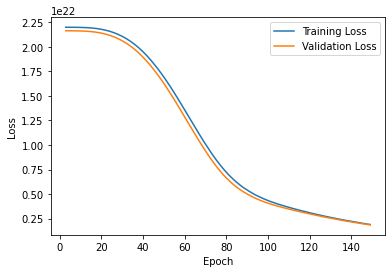

In [29]:
epochs = history.epoch

hist = history.history

plot_the_loss_curve(epochs, hist["loss"], 
                    hist["val_loss"])

In [30]:
tf_test_labels

<tf.Tensor: shape=(13, 3), dtype=float64, numpy=
array([[1.000e+05, 2.550e+11, 1.000e-05],
       [5.500e+05, 3.000e+11, 1.000e-05],
       [3.250e+05, 2.325e+11, 1.000e-05],
       [7.750e+05, 2.775e+11, 3.250e-05],
       [1.000e+06, 2.775e+11, 1.000e-04],
       [1.000e+06, 2.100e+11, 3.250e-05],
       [3.250e+05, 3.000e+11, 3.250e-05],
       [3.250e+05, 2.100e+11, 1.000e-05],
       [7.750e+05, 3.000e+11, 1.000e-04],
       [1.000e+05, 2.100e+11, 7.750e-05],
       [3.250e+05, 2.550e+11, 7.750e-05],
       [1.000e+05, 3.000e+11, 3.250e-05],
       [5.500e+05, 2.325e+11, 3.250e-05]])>

In [31]:
model.predict(tf_test_features)

array([[ 3.8695359e+05,  2.0557555e+11, -1.6217988e+05],
       [ 5.4836562e+05,  2.9131964e+11, -2.2982100e+05],
       [ 4.9899559e+05,  2.6509550e+11, -2.0913456e+05],
       [ 4.3944559e+05,  2.3346142e+11, -1.8417838e+05],
       [ 3.8345359e+05,  2.0372057e+11, -1.6071569e+05],
       [ 5.0740759e+05,  2.6956616e+11, -2.1266162e+05],
       [ 3.8033359e+05,  2.0206223e+11, -1.5940750e+05],
       [ 5.1685159e+05,  2.7458113e+11, -2.1661719e+05],
       [ 3.7199859e+05,  1.9763151e+11, -1.5591150e+05],
       [ 3.4993059e+05,  1.8590743e+11, -1.4666212e+05],
       [ 3.6151959e+05,  1.9207019e+11, -1.5152356e+05],
       [ 3.5456159e+05,  1.8836953e+11, -1.4860544e+05],
       [ 4.2478159e+05,  2.2567207e+11, -1.7803231e+05]], dtype=float32)

In [32]:
# 07/08/2021

# There is no point in trying to guess L in this case, as there is only one value for it.

# Even for multiple values of L, I think that it doesn't make sense to have [x, y] as inputs and at the same time try to 
# guess L, at least in the way I was innitially doing, because, (as the x values are linnearly spaced and allways the same
# for each L), we could easily check the max value of x and get L from that, without any need for a machine learning method.

In [33]:
# 07/08/2021

# Need to improve the way I feed the data to the model (had to extract it from DataFrames and convert the arrays to tensors...)

# Will try to figure out the best loss function, the best architecture for the model,
# tune the hyperparameters and try to get good results.

In [34]:
# 12/09/2021

# I am now only trying to find 3 parameters: E, q and I, as L was set to 1.0.

# After some tunning and experimenting, I'm still not able to say if the problem is with the architecture
# of the model being still too simple, if the problem is with the loss function or if it has to due with
# the lack of normalization of the features. I've noticed that the model is very bad at guessing
# the values for I, which are very small.